### Contexto

---

Rede Neural do tipo *Time Delay* com $n_p$ entradas $x(t-1)$, $x(t-2)$, etc. a depender do intervalo temporal histórico e $n_1$ neurônios em uma camada intermediária e 1 neurônio na camada de saída para $y = x(t)$.

Objetivo: Previsão do comportamento futuro do preço de uma determina mercadoria do mercado financeiro de ações.

Algoritmo de aprendizagem/ajuste: *backpropagation* e *momentum*. 

<img src="Fig/EPC5_Topologia_TDNN_Projeto3.jpg" width="600">


### Bibliotecas utilizadas

---

In [185]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Tratamento dos dados

---

In [153]:
# Leitura dos dados

data = pd.read_csv('data_510_RNA.txt', delim_whitespace=True)

In [169]:
data

,f(t)
0,0.1701
1,0.1023
2,0.4405
3,0.3609
4,0.7192
...,...
95,0.0195
96,0.4366
97,0.0924
98,0.7984


Text(0.5, 1.0, 'Histórico de preço da mercadoria X')

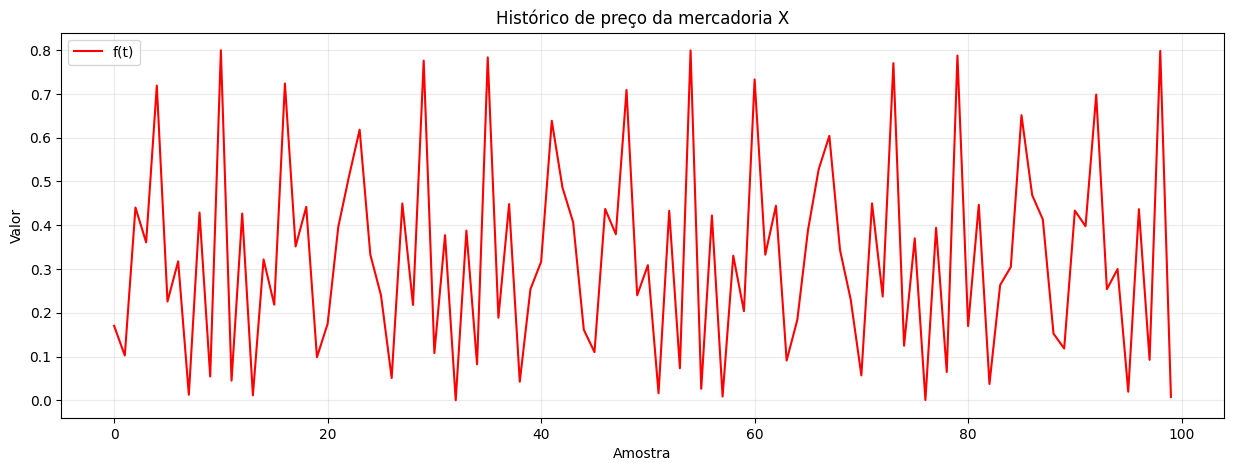

In [15]:
plot = data.plot(y='f(t)', figsize=(15, 5), color = '#FF0000')
plot.grid(alpha=0.25)
plt.xlabel('Amostra')
plt.ylabel('Valor')
plt.title('Histórico de preço da mercadoria X')

In [14]:
# Verifica a normalizacao

min = data.values.min()
max = data.values.max()

print(f'min = {min} \n max = {max}')

min = 0.0001 
 max = 0.8


Já normalizado

### Função que reordenada o vetor de dados históricos em tabela para a TDNN

In [170]:
## DATA
# X -> dados historicos

## NN STRUCTURE
# np -> num. de entradas

def dataframe_to_train(X, np):

    # tamanho da amostra temporal
    N = len(X)

    # Ajustando o index para 1...N
    X.index = range(1, N + 1)
    X = X.T
    # print(X)

    # Define numero de linhas
    n_rows = (N - np)
    
    # Cria a tabela com o index entre
    # (np+1) <= t <= N
    df_train = pd.DataFrame(index=range((np+1), (N+1)))

    # Preenchendo a tabela com os dados atrasados segundo np e d (saida desejada)
    for i in df_train.index:

        for j in range(1, (np)+1):

            df_train.loc[i, j] = float(X[i-j])
            
        df_train.loc[i, 'd'] = float(X[i])

    # renomeando as colunas
    column_names = [f'x{n}' for n in range(1, np + 1)] + ['d']

    df_train.columns = column_names

    return df_train

In [191]:
# Teste da função

X = data.copy()

data_teste = dataframe_to_train(X, 5)
data_teste

,x1,x2,x3,x4,x5,d
6,0.7192,0.3609,0.4405,0.1023,0.1701,0.2258
7,0.2258,0.7192,0.3609,0.4405,0.1023,0.3175
8,0.3175,0.2258,0.7192,0.3609,0.4405,0.0127
9,0.0127,0.3175,0.2258,0.7192,0.3609,0.4290
10,0.4290,0.0127,0.3175,0.2258,0.7192,0.0544
...,...,...,...,...,...,...
96,0.2998,0.2538,0.6987,0.3978,0.4334,0.0195
97,0.0195,0.2998,0.2538,0.6987,0.3978,0.4366
98,0.4366,0.0195,0.2998,0.2538,0.6987,0.0924
99,0.0924,0.4366,0.0195,0.2998,0.2538,0.7984


### Treinamento da rede neural TDNN

---

In [192]:
# valor maximo de epocas
MAX_EPOCA = int(10e+6)

# Taxa de aprendizado
n = 0.1

# Fator de momentum
m = 0.8

# Precisao
p = 0.5*10e-6

Funcao logistica (sigmoide):

$f(u) = 1 / (1 + e^{(-β*u)})$

sendo $β$ o fator de inclinacao da funcao e $u$ a entrada

In [181]:
def func_ativacao(u, beta):

    g = 1 / (1 + np.exp(-beta * u))

    return g

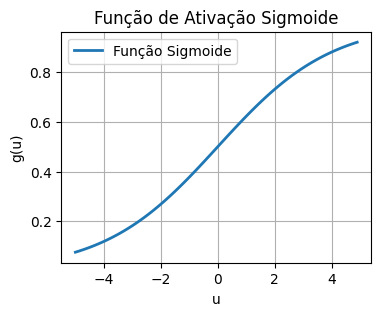

In [186]:
# Plot Funcao de Ativacao

u = np.arange(-5,5,0.1)
resultado = func_ativacao(u, 0.5)

plt.figure(figsize=(4, 3))
plt.plot(u, resultado, label='Função Sigmoide', linewidth=2)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Função de Ativação Sigmoide')
plt.grid(True)
plt.legend()
plt.show()

In [187]:
def func_ativacao_derivada(u, beta):
    
    gd = (beta * np.exp(-beta * u))/((np.exp(-beta * u) + 1) ** 2)

    return gd

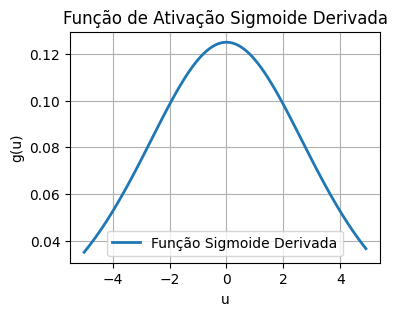

In [189]:
# Plot Funcao de Ativacao Derivada

u = np.arange(-5,5,0.1)
resultado = func_ativacao_derivada(u, 0.5)

plt.figure(figsize=(4, 3))
plt.plot(u, resultado, label='Função Sigmoide Derivada', linewidth=2)
plt.xlabel('u')
plt.ylabel('g(u)')
plt.title('Função de Ativação Sigmoide Derivada')
plt.grid(True)
plt.legend()
plt.show()

In [86]:
## DATA
# X -> dados historicos

## PARAMETERS
# n -> taxa de aprendizado
# m -> fator de momentum
# p -> precisao
# beta -> inclinacao da funcao de ativao
# MAX_EPOCA -> épocas máximas de treinamento

## NN STRUCTURE
# nt -> num. de treinamentos
# np -> num. de entradas
# n1 -> num. de neuronio na H.L. 1 (H.L. = camada escondida)

def treinamento_TDNN(X, n, m, p, beta, MAX_EPOCA, nt, np, ni):

    # Selecionando as ultimas np amostras dos dados historicos (X)
    data_train = dataframe_to_train(X, np)

    # SEPARAR EM PREDITORAS E ALVO

    # Lista de matrizes de pesos sinapticos iniciais (i) e ajustados (adj) de cada camada
    lista_Wi_1 = []
    lista_Wi_2 = []

    lista_W_1_adj = []
    lista_W_2_adj = []
    
    # Inicializando os treinamentos
    for n_treino in range(nt):

        print('-'*30)
        print(f'Treinamento TDD (np = -{np}) numero: {n_treino + 1}')
        print('-'*30)
        
        # Contador de epocas
        epoca = 0

        # Vetor de erros
        lista_erros = np.zeros(MAX_EPOCA)
        # E(t) = x(t) - y(t), onde (np+1) <= t <= N
        # sendo N = len(X)
        # portanto: Erro = d(t) - y(t)

        # Pesos aleatorios entre 0 e 1 do {n_treino}
        # (ni, 1) -> (ni neuronios, 1 entrada)
        W_1 = np.random.randn(ni,1)
        lista_Wi_1.append(W_1)

        # Pesos aleatorios entre 0 e 1 do n_treino
        # (1, ni) -> (1 neuronios, ni entradas)
        W_2 = np.random.randn(1, ni)
        lista_Wi_2.append(W_2)

        # matriz sinaptica anterior = atual (para a primeira epoca)
        W_1_ant = W_1
        W_2_ant = W_2

        while(epoca < MAX_EPOCA):

            # print(f'epoca {epoca}')

            #######################
            # ETAPAS FEED FORWARD #
            #######################
            
            # **CAMADA 1 - HIDDEN**

            # Entrada I_1 = X * W_1
            I_1 = X.dot(W_1.T)

            # Saida Y_1 = g(I_1)
            Y_1 = func_ativacao(I_1, beta)
            
            # **CAMADA 2 - OUT**

            # Adicao do bias
            Y_1 = pd.DataFrame(Y_1)
            Y_1['bias'] = -1
            Y_1 = np.array(Y_1)

            # Entrada I_2 = Y_1 * W_2
            I_2 = (Y_1).dot(W_2.T)

            # Saida Y_2 = g(I_2)
            Y_2 = func_ativacao(I_2, beta)

            # Erro da previsao FOWARD
            erro[epoca] = np.mean((d - Y_2) ** 2)
            
            ######################
            # ETAPAS DE BACKWARD #
            ######################

            # **CAMADA 2 - OUT**

            # ta = termo de aprendizagem

            # tm = termo de momentum

            gd_2 = func_ativacao_derivada(I_2, beta)
            erro_2 = d - Y_2
            delta_2 = erro_2 * gd_2
            
            ta_2 = ((n * delta_2).T).dot(Y_1)

            tm_2 = m * (W_2 - W_2_a)

            W_2_bp = W_2 + tm_2 + ta_2
            
            # **CAMADA 1 - HIDDEN**

            gd_1 = func_ativacao_derivada(I_1, beta)

            delta_1 = (delta_2.dot(W_2_bp[:, :-1])) * gd_1

            ta_1 = ((n * delta_1).T).dot(X)

            tm_1 = m * (W_1 - W_1_a)

            W_1_bp = W_1 + tm_1 + ta_1

            #########################################
            # Calculo das saidas ajustadas Y_2_n_bp #
            #########################################

            I_1_bp = X.dot(W_1_bp.T)
            Y_1_bp = func_ativacao(I_1_bp, beta)

            # Adicao do bias
            Y_1_bp = pd.DataFrame(Y_1_bp)
            Y_1_bp['bias'] = -1
            Y_1_bp = np.array(Y_1_bp)

            I_2_bp = (Y_1_bp).dot(W_2_bp.T)
            Y_2_bp = func_ativacao(I_2_bp, beta)

            # Erro da previsao PÓS-BACKWARD
            erro[epoca + 1] = np.mean((d - Y_2_bp) ** 2)

            # Incremente de epoca
            epoca = epoca + 1

            # print(f'epoca{epoca} - {abs(erro[epoca] - erro[epoca - 1])} < {p}')

            # Busca pela precisao
            if (abs(erro[epoca] - erro[epoca - 1]) < p):

                print(f'Convergência em {epoca} épocas')
                print(f'Erro Médio Quadrático = {np.mean(erro)}')

                # Armazena as matrizes de pesos sinapticos ajustados na lista
                lista_W_1_bp.append(W_1_bp)
                lista_W_2_bp.append(W_2_bp)
                
                # Grafico do erro
                plt.figure()
                plt.plot(np.arange(epoca+1), erro[:epoca+1], linewidth=1)
                ttl = f'Erro pelas épocas (Treinamento {n_treino + 1})'
                plt.title(ttl)
                plt.ylabel('Erro Quadrático Médio')
                plt.xlabel('Épocas')
                
                plt.xlim(0, epoca)
                plt.ylim(0, 1)
                plt.grid()
                plt.savefig(f'Fig/EPC5_n_treino{n_treino + 1}.pdf', format='pdf')
                plt.show()

                break

            # Atualiza as matrizes iniciais com as ajustadas
            W_1_a = W_1 
            W_2_a = W_2

            W_1 = W_1_bp
            W_2 = W_2_bp

    return lista_W_1_bp, lista_W_2_bp

------------------------------
Treinamento numero: 1
------------------------------
Convergência em 242 épocas
Erro Médio Quadrático = 1.1732792109890755e-06


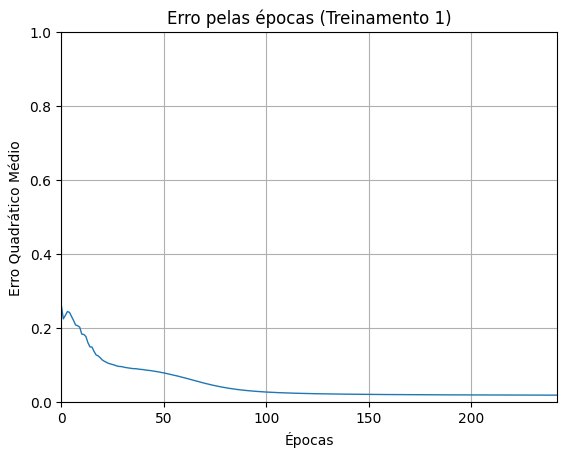

------------------------------
Treinamento numero: 2
------------------------------
Convergência em 236 épocas
Erro Médio Quadrático = 1.1289680917139654e-06


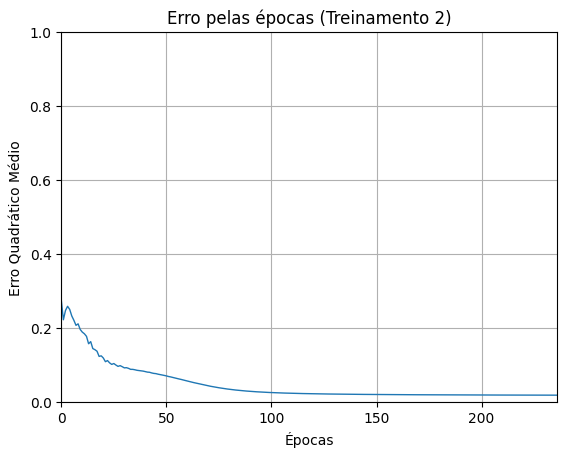

------------------------------
Treinamento numero: 3
------------------------------
Convergência em 279 épocas
Erro Médio Quadrático = 4.125391802100873e-06


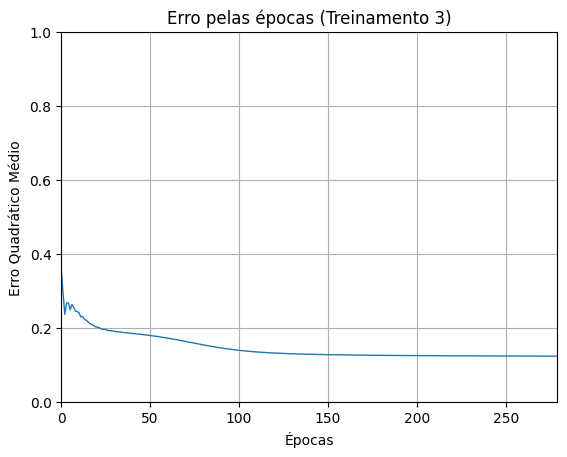

------------------------------
Treinamento numero: 4
------------------------------
Convergência em 149 épocas
Erro Médio Quadrático = 2.1065608891483944e-06


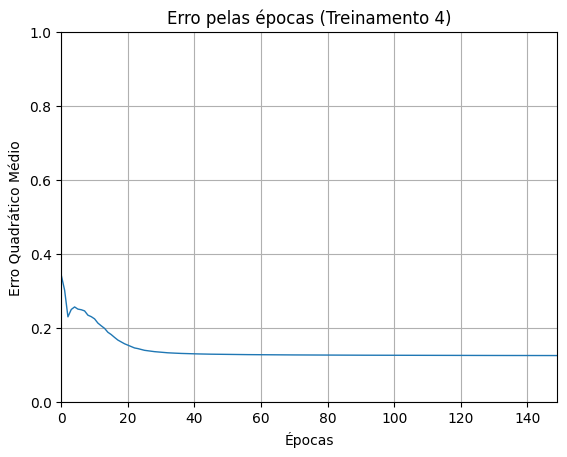

------------------------------
Treinamento numero: 5
------------------------------
Convergência em 235 épocas
Erro Médio Quadrático = 1.0407142903404535e-06


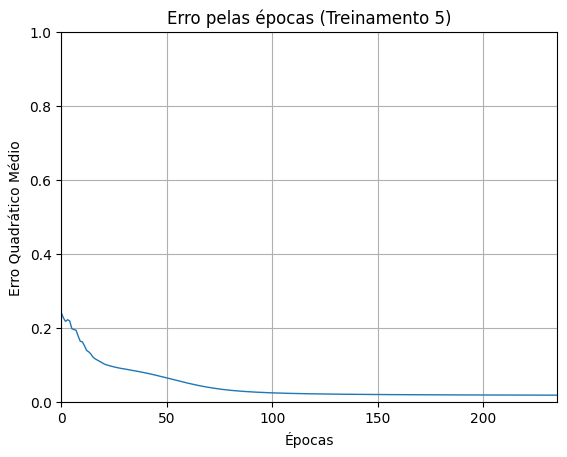

In [87]:
lista_W_1_bp, lista_W_2_bp = treinamento(X, d, n, m, MAX_EPOCA, p, 0.5)

In [102]:
# Treino 5 (n=4) apresentou o menor erro médio quadrático 

### Teste da rede neural

---

In [82]:
data_teste = pd.read_csv('data_teste_59_RNA.txt', delim_whitespace=True)

In [83]:
# Separacao dos dados de teste

x1_teste = data_teste['x1'].copy()
x2_teste = data_teste['x2'].copy()
x3_teste = data_teste['x3'].copy()
x4_teste = data_teste['x4'].copy()
X_teste = pd.concat([x1_teste, x2_teste, x3_teste, x4_teste], axis=1)

# Adiciona coluna do limiar de ativacao = -1 (bias) no conjunto de dados
X_teste['bias'] = -1

d1_teste = data_teste['d1'].copy()
d2_teste = data_teste['d2'].copy()
d3_teste = data_teste['d3'].copy()
d_teste = pd.concat([d1_teste, d2_teste, d3_teste], axis=1)

In [84]:
X_teste = np.array(X_teste)

d_teste = np.array(d_teste)

In [104]:
def teste(X_teste, lista_W_1_bp, lista_W_2_bp, beta, n_treino):

    #######################
    # ETAPAS FEED FORWARD #
    #######################
    
    # entradas I_1 e saida Y_1 da camada 1

    I_1 = X_teste.dot(lista_W_1_bp[n_treino].T)

    Y_1 = func_ativacao(I_1, beta)

    # Adicao do bias
    Y_1 = pd.DataFrame(Y_1)
    Y_1['bias'] = -1
    Y_1 = np.array(Y_1)
    
    # entrada I_2 e saida Y_2 da camada 2 de saída

    I_2 = (Y_1).dot(lista_W_2_bp[n_treino].T)

    Y_2 = func_ativacao(I_2, beta)

    return Y_2

In [117]:
Y_saida = teste(X_teste, lista_W_1_bp, lista_W_2_bp, 0.5, 4)

Y_saida

array([[1.11644144e-06, 1.07057792e-02, 9.92401648e-01],
       [9.99901802e-01, 1.93480088e-04, 3.41548396e-10],
       [9.55580269e-07, 1.07890869e-02, 9.93647986e-01],
       [7.24564190e-03, 9.50954888e-01, 1.12060355e-03],
       [4.89050687e-06, 1.03959789e-01, 9.20696450e-01],
       [9.50321828e-01, 5.17535396e-02, 2.00028439e-07],
       [2.11692073e-03, 9.66072176e-01, 3.41186550e-03],
       [5.84503629e-04, 9.56716301e-01, 1.45276620e-02],
       [9.81532460e-01, 2.39447798e-02, 5.91489289e-08],
       [9.98192640e-01, 2.26481904e-03, 7.09479763e-09],
       [6.80346977e-04, 9.56037541e-01, 1.39585280e-02],
       [9.92601797e-01, 8.06884108e-03, 2.67088522e-08],
       [4.91282225e-07, 6.07183073e-03, 9.97206475e-01],
       [7.42095413e-07, 8.77718740e-03, 9.94756066e-01],
       [4.00064079e-07, 4.47155741e-03, 9.98161015e-01],
       [9.95538632e-01, 5.59318237e-03, 1.01105440e-08],
       [2.54556828e-05, 2.49963831e-01, 6.85014388e-01],
       [2.82991590e-03, 9.60938

### Classificação dos resultados

---

In [ ]:
def classificacao(data):

    data_classificada = data.copy()
    
    data_classificada[data >= 0.5] = 1
    data_classificada[data < 0.5] = 0
    
    return data_classificada

In [118]:
Y_saida_final = classificacao(Y_saida)

Y_saida_final

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Verificação da precisão (Acertos)

Caso haja algum número diferente de zero (0) alguma previsão está errada

---

In [119]:
Y_saida_final - d_teste

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Precisão de 100% !